# Training the model to distinguish damaged cars from undamaged ones 
- I will take the pre-trained model `resnet18` as the basis and fine-tune it on internet data.
- I will use deep learning libraries from fastai for model training.
- I will save the model in `.pkl` format for further use in the stremlit application and telegram bot.

## Imports

In [1]:
!pip install -Uqq fastai
!pip install -q duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 933.8 kB/s eta 0:00:00


In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

def search_images(term, max_images=150):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

## Loading data for fine-tuning

In [3]:
searches = 'Damaged car','Car'
path = Path('Damaged_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Damaged car photo'
Searching for 'Car photo'


In [4]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

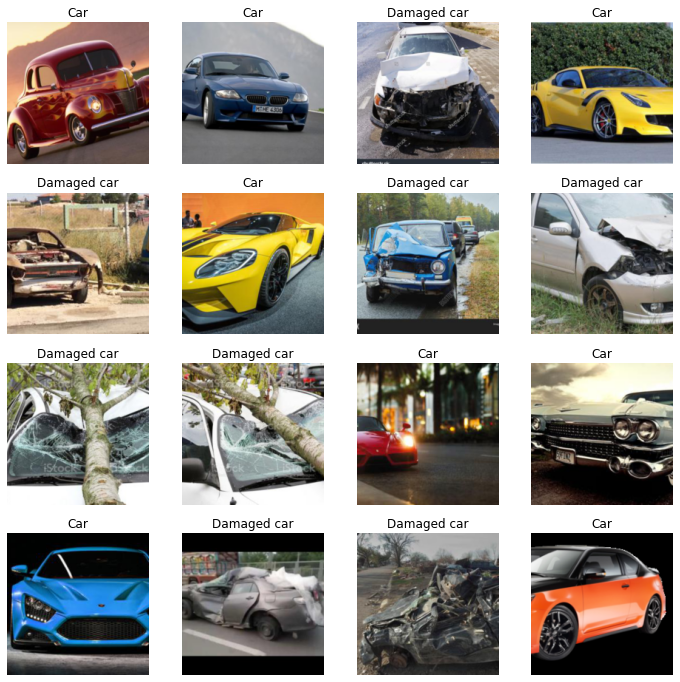

In [5]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='crop')]
)

dls = cars.dataloaders(path, bs=32)

dls.show_batch(max_n=16)

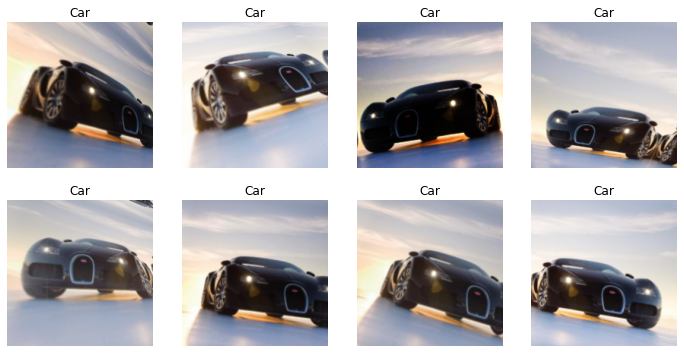

In [6]:
cars = cars.new(item_tfms=Resize(192), batch_tfms=aug_transforms(mult=2))
dls = cars.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Learning

In [7]:
model = vision_learner(dls, resnet18, metrics=error_rate)
model.fine_tune(7)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.071738,0.499533,0.185185,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.383100,0.290929,0.148148,00:02
1,0.331122,0.289491,0.092593,00:01
2,0.318914,0.204965,0.074074,00:02
3,0.260128,0.161238,0.055556,00:01
4,0.223494,0.105127,0.037037,00:01
5,0.207362,0.076370,0.037037,00:01
6,0.187078,0.059275,0.037037,00:01


## Checking the result

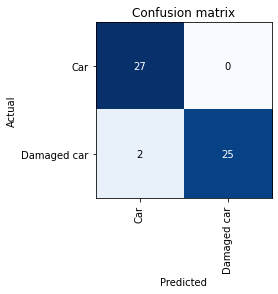

In [8]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

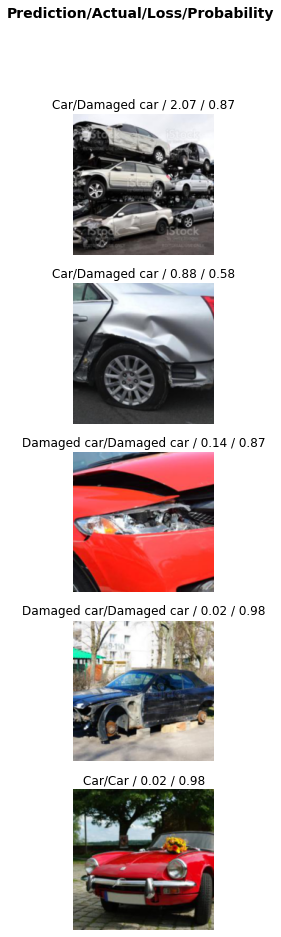

In [9]:
interp.plot_top_losses(5, nrows=5)

## Model saving

In [10]:
 model.export('model.pkl')